Keeping classes: ['myrcene', 'caryophyllene', 'limonene', 'terpinolene', 'pinene', 'ocimene']
Using 58 numeric effect features

Classification report (no unknown class):

               precision    recall  f1-score   support

caryophyllene       0.22      0.12      0.15        91
     limonene       0.20      0.11      0.14        74
      myrcene       0.53      0.83      0.64       239
      ocimene       0.00      0.00      0.00         3
       pinene       0.00      0.00      0.00        20
  terpinolene       0.15      0.03      0.05        61

     accuracy                           0.45       488
    macro avg       0.18      0.18      0.17       488
 weighted avg       0.35      0.45      0.37       488



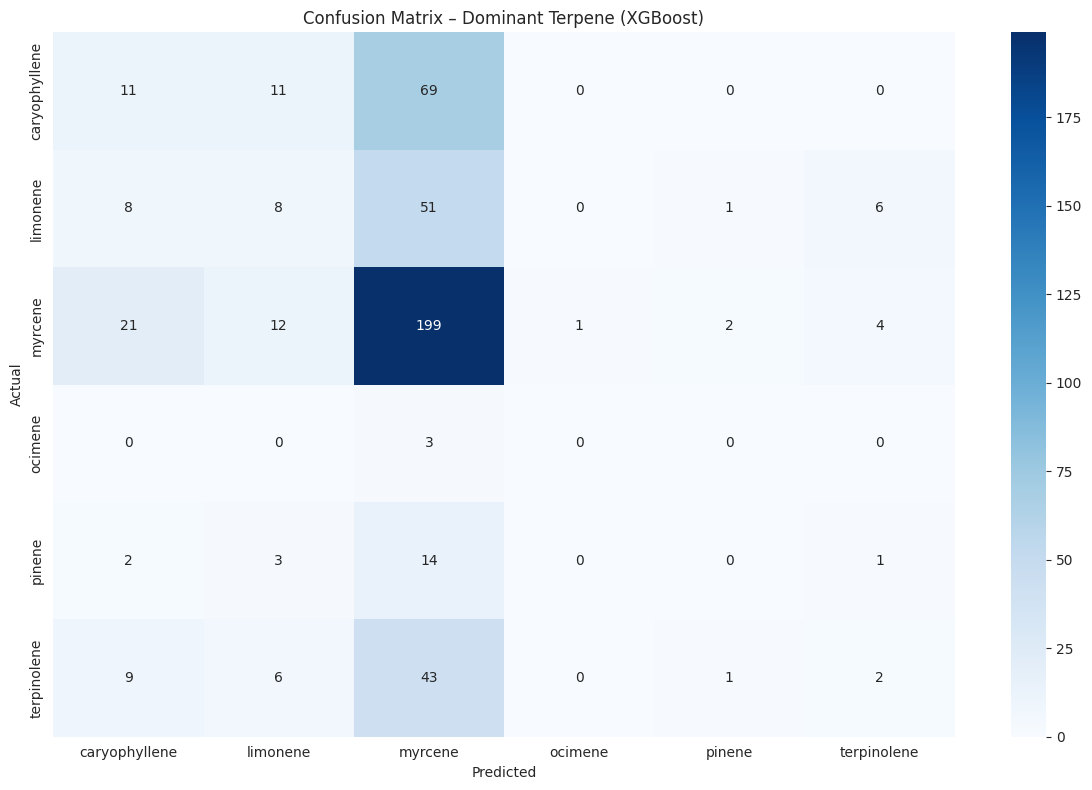

Sample top‑3 terpene predictions for 5 test strains:
Strain 1: ['myrcene', 'terpinolene', 'limonene']
Strain 2: ['myrcene', 'caryophyllene', 'pinene']
Strain 3: ['myrcene', 'limonene', 'caryophyllene']
Strain 4: ['myrcene', 'caryophyllene', 'limonene']
Strain 5: ['myrcene', 'limonene', 'caryophyllene']


In [10]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

"""
XGBoost Terpene Predictor (final)
--------------------------------
1. Load + clean Leafly CSV
2. Drop rows with *unknown* terpene
3. Keep terpene classes with ≥10 samples
4. Convert % effect columns → float
5. Train XGBoost multiclass model on effects + THC/CBD
6. Show classification report & confusion matrix
7. Helper function to return top‑k terpene profile per strain
"""

# === 1. Load & basic clean ===
df = pd.read_csv("data/leafly_strain_data_project.csv")
df.drop(columns=["img_url"], errors="ignore", inplace=True)

# --- THC / CBD parsing ---
# THC always present as a % string
df["thc"] = df["thc_level"].astype(str).str.extract(r"(\d+\.?\d*)")[0].astype(float)

# CBD may be missing → create numeric column either way
if "cbd" in df.columns:
    df["cbd"] = pd.to_numeric(df["cbd"], errors="coerce").fillna(0.0)
else:
    df["cbd"] = 0.0  # broadcast scalar -> Series

# --- dominant terpene normalisation ---
if "most_common_terpene" in df.columns:
    df["dominant_terpene"] = df["most_common_terpene"]
else:
    df["dominant_terpene"] = df.get("dominant_terpene", "unknown")

df["dominant_terpene"] = df["dominant_terpene"].fillna("unknown").str.lower()

# === 2. Drop unknowns & rare classes ===
df = df[df["dominant_terpene"] != "unknown"].copy()
class_counts = df["dominant_terpene"].value_counts()
keep_classes = class_counts[class_counts >= 10].index
print("Keeping classes:", keep_classes.tolist())
df = df[df["dominant_terpene"].isin(keep_classes)]

# === 3. Numeric feature engineering ===
skip_cols = {
    "name", "strain_name", "description", "thc_level", "dominant_terpene",
    "most_common_terpene", "thc", "cbd"
}

effect_cols = []
for col in df.columns:
    if col in skip_cols:
        continue
    # attempt numeric conversion; skip column if fails
    try:
        df[col] = (
            df[col]
            .astype(str)
            .str.replace("%", "", regex=False)
            .replace("", "0")
            .fillna("0")
            .astype(float)
        )
        effect_cols.append(col)
    except ValueError:
        continue

print(f"Using {len(effect_cols)} numeric effect features")

# === 4. Train / test split ===
X = df[effect_cols + ["thc", "cbd"]].astype(np.float32)
y = df["dominant_terpene"].astype(str)
le = LabelEncoder()
y_enc = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, stratify=y_enc, test_size=0.2, random_state=42
)

# === 5. XGBoost training ===
model = xgb.XGBClassifier(eval_metric="mlogloss", random_state=42)
model.fit(X_train, y_train)

# === 6. Evaluation ===
y_pred = model.predict(X_test)
print("\nClassification report (no unknown class):\n")
print(classification_report(le.inverse_transform(y_test), le.inverse_transform(y_pred)))

cm = confusion_matrix(le.inverse_transform(y_test), le.inverse_transform(y_pred), labels=le.classes_)
plt.figure(figsize=(12, 8))
sns.heatmap(pd.DataFrame(cm, index=le.classes_, columns=le.classes_), annot=True, fmt="d", cmap="Blues")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("Confusion Matrix – Dominant Terpene (XGBoost)")
plt.tight_layout()
plt.show()

# === 7. OPTIONAL: Top‑k terpene profile helper ===

def top_k_proba(model, X, label_encoder, k=3):
    """Return top‑k predicted class labels for each row as a list of lists."""
    proba = model.predict_proba(X)
    top_k_idx = np.argsort(proba, axis=1)[:, -k:][:, ::-1]  # highest → lowest
    # Convert indices to label strings row‑by‑row
    return [[label_encoder.classes_[idx] for idx in row] for row in top_k_idx]

# Show example top‑3 predictions (first 5 test rows)
sample_top3 = top_k_proba(model, X_test.iloc[:5], le, k=3)
print("Sample top‑3 terpene predictions for 5 test strains:")
for i, preds in enumerate(sample_top3, 1):
    print(f"Strain {i}: {preds}")
